In [2]:
import os
import tensorflow as tf
import sys
import numpy as np
import ROOT
import glob
import time

%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## TFRecord related methods

In [3]:
################################################
################################################
def _array_float32_feature(ndarray):
    return lambda array: tf.train.Feature(float_list=tf.train.FloatList(value=array.reshape(-1)))
################################################
##FIXME: reduce precision to 32 bits
################################################
def _array_int64_feature(ndarray):
    return lambda array: tf.train.Feature(int64_list=tf.train.Int64List(value=array.reshape(-1)))
################################################
################################################
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
################################################
################################################
def create_features(x, y):
    dtype_feature_x = _array_float32_feature(x)
    dtype_feature_y = _array_int64_feature(y)
    d_feature = {}
    d_feature['UVW_data'] = dtype_feature_x(x)
    d_feature['label'] = dtype_feature_y(y)
    features = tf.train.Features(feature = d_feature)
    return features
################################################
################################################
def createWriter(fileName):
    result_tf_file = fileName + '.tfrecords'
    writer = tf.io.TFRecordWriter(result_tf_file)
    return writer, result_tf_file
################################################
################################################
def saveSingleExampleToTFRecord(writer, features):
    example = tf.train.Example(features = features)
    serialized = example.SerializeToString()
    writer.write(serialized)
################################################
################################################

## Methods reading the ROOT files

features.shape:  (512, 92, 3)
labels.shape:  (2,)
(array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]]), array([0, 0]))


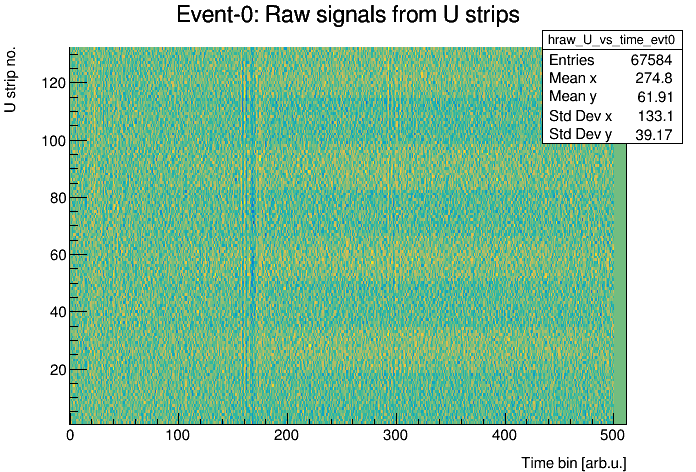

In [5]:
################################################
################################################
def get_numpy_from_histo(root_histo):
    nBinsX = root_histo.GetNbinsX()
    nBinsY = root_histo.GetNbinsY()
    nBinsY = 92 ##FIXME: Need uniform frame size
    numpy_histo = np.zeros((nBinsX,nBinsY))
    for iBinX in range(0, nBinsX):
        for iBinY in range(0, nBinsY):
            numpy_histo[iBinX, iBinY] = root_histo.GetBinContent(iBinX, iBinY)
    return numpy_histo
################################################
##FIX ME: provide source of labels
################################################
def read_root(fileName, normalize=False):
    projection_histos = {"U":0, "V":0, "W":0}
    rootFile = ROOT.TFile(fileName,"r")
    keysList = rootFile.GetListOfKeys()
    numberOfHistos = len(keysList)
    label = 0
    index = 0
    while index<numberOfHistos:
        objName = keysList[index].GetName()
        eventId = objName.split("evt")[1]
        for projName in projection_histos.keys():
            histo_name = "hraw_"+projName+"_vs_time_evt"+eventId
            root_histo = rootFile.Get(histo_name)
            numpy_histo = get_numpy_from_histo(root_histo)
            if normalize: 
                maxValue = np.amax(numpy_histo)
                numpy_histo = np.where(numpy_histo<0,0,numpy_histo/maxValue)
            #print("histo name: ",histo_name," shape:",numpy_histo.shape)
            projection_histos[projName] = numpy_histo
       
        features = np.stack(arrays=list(projection_histos.values()), axis=2)
        features_cropped = np.stack(arrays=list(projection_histos.values()), axis=2)
        labels = np.array([0,0])
        if index==0:
            print("features.shape: ",features.shape)
            print("labels.shape: ",labels.shape)
        index += 3 
        #print("eventId:",eventId)
        yield features, labels 
################################################
##Test histogram reading
################################################
fileName = "/scratch/akalinow/ProgrammingProjects/MachineLearning/ELITPC/data/UVWProjections_2018-06-19T15:13:33.941_0008.root"
fileName = "/scratch/akalinow/ProgrammingProjects/MachineLearning/ELITPC/data/ProjectionHistos_2021-09-10T12:08:25.751_0.root"
fileName = "/scratch/akalinow/ProgrammingProjects/MachineLearning/ELITPC/data/ProjectionHistos_2021-06-16T17:46:28.582_0.root"

f = ROOT.TFile(fileName)
h_U = f.Get("hraw_U_vs_time_evt0")
c1 = ROOT.TCanvas()
c1.Draw()
h_U.Draw("col")

for item in read_root(fileName):
    print(item)
    break

## The final conversion methods

In [6]:
################################################
################################################
def ROOT_to_TFRecord(normalize=False):
    path = "/scratch/akalinow/ProgrammingProjects/MachineLearning/ELITPC/data/"
    file_list = glob.glob(path + "ProjectionHistos_2021-06-16*.root")
    number_of_files = len(file_list)
    number_of_examples = 0
    print ("Found {} files".format(number_of_files))
    start_time = time.perf_counter()
    writer, result_tf_file = createWriter(fileName)
    for idx, file in enumerate(file_list):
        for numpy_histogram, labels in read_root(file, normalize=normalize):
            features = create_features(numpy_histogram, labels)
            saveSingleExampleToTFRecord(writer, features)
            number_of_examples+=1
        if idx == number_of_files - 1:
            writer.close()
            print ("Serializing {} examples into {} done!".format(number_of_examples,result_tf_file))
            print("Execution time: {:.2f} seconds".format(time.perf_counter() - start_time))
################################################
################################################
ROOT_to_TFRecord(normalize=False)
################################################
################################################

Found 5 files
features.shape:  (512, 92, 3)
labels.shape:  (2,)
features.shape:  (512, 92, 3)
labels.shape:  (2,)
features.shape:  (512, 92, 3)
labels.shape:  (2,)
features.shape:  (512, 92, 3)
labels.shape:  (2,)
features.shape:  (512, 92, 3)
labels.shape:  (2,)
Serializing 4815 examples into /scratch/akalinow/ProgrammingProjects/MachineLearning/ELITPC/data/ProjectionHistos_2021-06-16T17:46:28.582_0.root.tfrecords done!
Execution time: 589.58 seconds


## Read the TFRecord format

In [18]:
featuresShape = (512, 92, 3)
cropped_featuresShape = (64, 64, 3)
labelsShape = (2,)
################################################
################################################
feature_description = {
    'UVW_data': tf.io.FixedLenFeature(featuresShape, tf.float32),
    'label': tf.io.FixedLenFeature(labelsShape, tf.int64),
}

def _parse_function(example_proto):
  return tf.io.parse_single_example(example_proto, feature_description)
################################################
################################################
def readTFRecordFile(fileNames):
    raw_dataset = tf.data.TFRecordDataset(fileNames)
    return raw_dataset.map(_parse_function)
################################################
################################################
#fileNames = ["UVWProjections_2018-06-19T15:13:33.941_0008.tfrecords"]
fileNames = ["ProjectionHistos_2021-09-10T12:08:25.751.root.tfrecords"]
dataset = readTFRecordFile(fileNames)

for item in dataset.take(1):
      print(repr(item))      

{'UVW_data': <tf.Tensor: shape=(512, 92, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, 'label': <tf.Tensor: 

2021-10-26 11:34:13.077142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-26 11:34:13.077166: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-26 11:34:13.077187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-10-26 11:34:13.077856: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-26 11:34:13.138032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
